In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [33]:
train = pd.read_csv(r'C:\Users\Nino\Desktop\Toxic Comments\train.csv')
test = pd.read_csv(r'C:\Users\Nino\Desktop\Toxic Comments\test.csv')
sub = pd.read_csv(r'C:\Users\Nino\Desktop\Toxic Comments\sample_submission.csv')

In [34]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [35]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Some of these comments that do not have any flags are actually clean. Let's determine how many there are.

In [36]:
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums == 0)

In [39]:
print('Number of clean comments: {:,} or {:.2%}'.format(train['clean'].sum(), train['clean'].sum() / train.shape[0]))

Number of clean comments: 143,346 or 89.83%


In [5]:
# train['comment_text'].loc[train['toxic'] == 1][:1].values[0]

Let's take a peak at some of these comments

In [40]:
# Display one comment from each label
for i in train.columns[2:]:
    print('[{}] \t {}'.format(i, train['comment_text'].loc[train[i] == 1][:1].values[0]))

[toxic] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[severe_toxic] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[obscene] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[threat] 	 Hi! I am back again!
Last warning!
Stop undoing my edits or die!
[insult] 	 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
[identity_hate] 	 You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
[clean] 	 Explanation
Why t

What a bunch of meanies.

It looks like a comment can have multiple classifications (ie being toxic as well as obscene and an insult).

Text(0.5, 0, 'Label ')

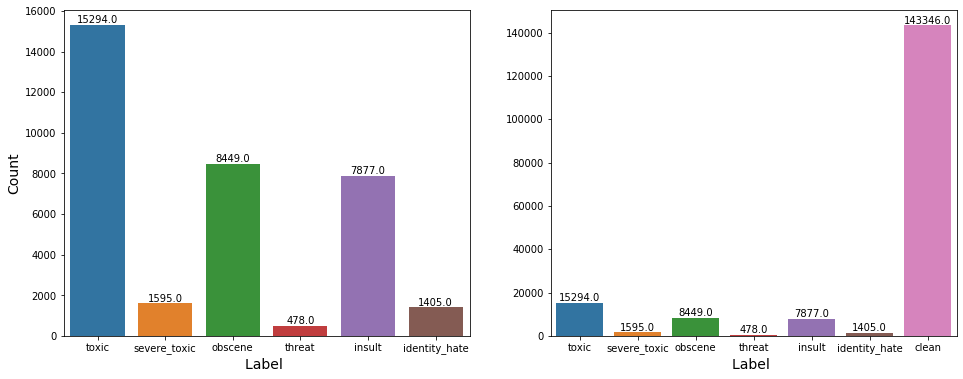

In [76]:
w = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].iloc[:].sum(axis=0)
x = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']].iloc[:].sum(axis=0)


fig, ax = plt.subplots(1,2, figsize=(16,6))
a = sns.barplot(w.index, w.values, ax=ax[0])
b = sns.barplot(x.index, x.values, ax=ax[1])

rects = b.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    b.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Label ', fontsize=14)
b.set_xlabel('Label ', fontsize=14)

As expected, the label counts are not evenly distributed. Toxic comments heavily outweight any other label, while threats are quite rare.

However, toxic comments may have multiple labels.

Text(0.5, 0, 'Number of multi-label counts ')

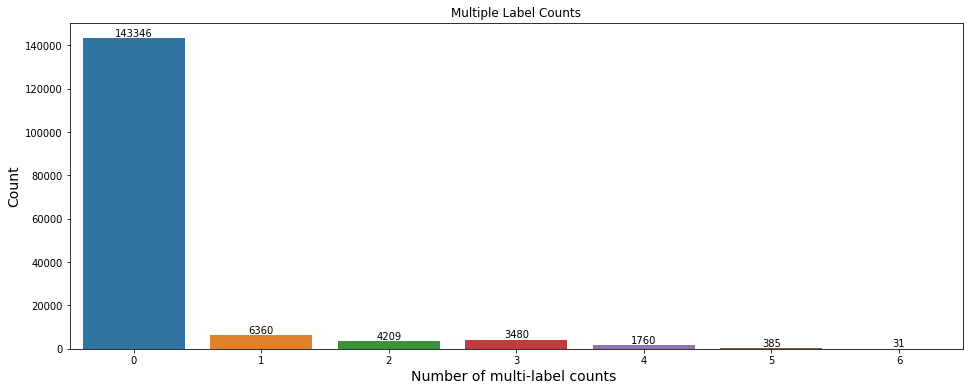

In [87]:
x = rowsums.value_counts()


fig, ax = plt.subplots(1,1, figsize=(16,6))
a = sns.barplot(x.index, x.values)


rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

a.set_title('Multiple Label Counts')
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Number of multi-label counts ', fontsize=14)

In [108]:
main_col = "toxic"
corr_mats = []
temp_df = train.iloc[:, 2:-1]

for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# cell highlighting

def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]



out = out.style.apply(highlight_min, axis=0)
out

From the above chart which shows the counts of labels, we see that:
    - toxic = 15294
    - severe_toxic = 1595
    - obscene = 8449
    - threat = 478
    - insult = 7877
    - identity_hate = 1405
    
So now from the confusion matrix above, we can see that:
1. A severe_toxic comment is **always** toxic
2. Almost all obscene comments are toxic
3. Almost all threats, insults, and identity are toxic

## WordCloud - Most Frequent Words

In [111]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Initalize stopwords
stopword = set(STOPWORDS)

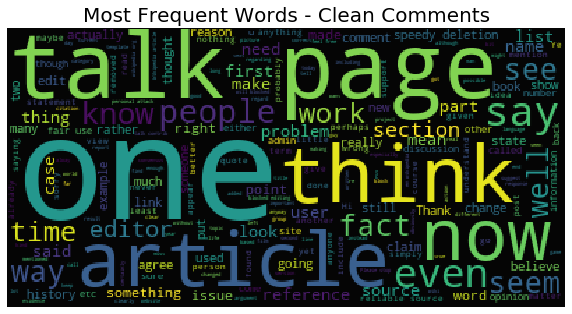

In [142]:
dfclean = train[train['clean'] == True]
cleanComments = dfclean['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(cleanComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Clean Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

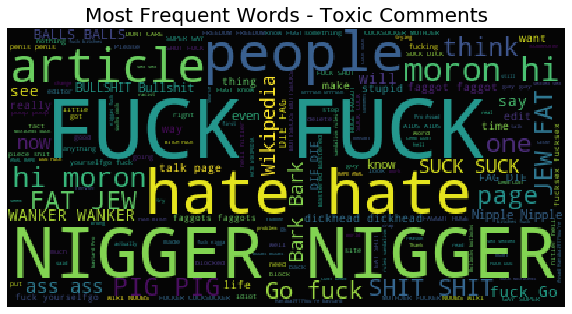

In [143]:
dftoxic = train.loc[train['toxic'] == 1]
toxicComments = dftoxic['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(toxicComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Toxic Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

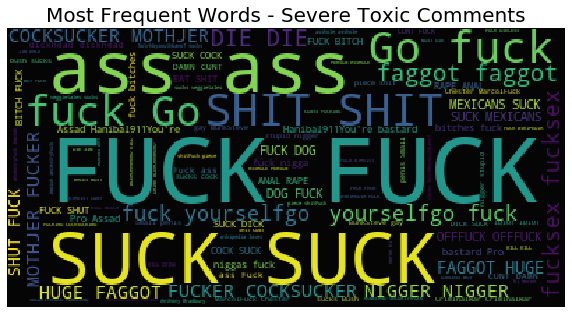

In [134]:
dfSeveretoxic = train.loc[train['severe_toxic'] == 1]
SeveretoxicComments = dfSeveretoxic['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(SeveretoxicComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Severe Toxic Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

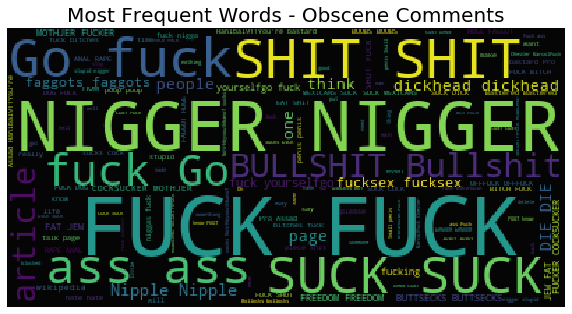

In [135]:
dfobscene = train.loc[train['obscene'] == 1]
obsceneComments = dfobscene['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(obsceneComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Obscene Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

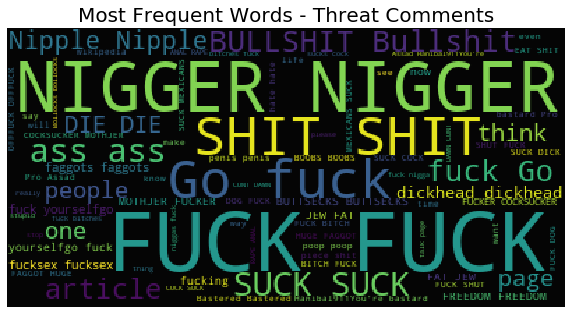

In [136]:
dfthreat = train.loc[train['threat'] == 1]
threatComments = dfobscene['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(threatComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Threat Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

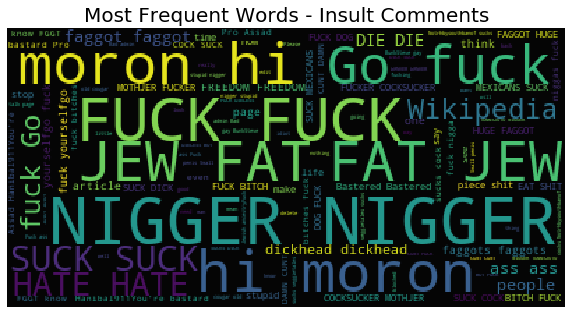

In [137]:
dfinsult = train.loc[train['insult'] == 1]
insultComments = dfinsult['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(insultComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Insult Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

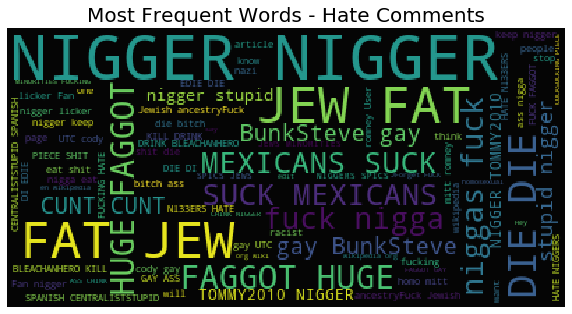

In [138]:
dfhate = train.loc[train['identity_hate'] == 1]
hateComments = dfhate['comment_text'].values

cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
cloud.generate(" ".join(hateComments))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Frequent Words - Hate Comments", fontsize=20)
plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

## Data Cleanup & Feature Engineering

In [149]:
# Merge train & test dataset and reset index

merged = pd.concat([train.iloc[:, 0:2], test.iloc[:, 0:2]])
df = merged.reset_index(drop=True)

In [172]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Note that if we remove punctuation, we will end up removing complete sentences. Instead we will count various metrics in order to further understand the data.

In [159]:
# Find the number of new lines '\n'
df['sentenceCount'] = df['comment_text'].apply(lambda x: len(re.findall("\n", str(x))) + 1)

In [160]:
# Number of words 
df['wordCount'] = df['comment_text'].apply(lambda x: len(str(x).split()))

In [162]:
# Unique number of words
df['uniqueWordCount'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

In [166]:
# Number of letters
df['letterCount'] = df['comment_text'].apply(lambda x: len(str(x)))

In [169]:
# Punctuation count
df['puncCount'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [180]:
# import string
# import re
# from nltk.corpus import stopwords
# from nltk import pos_tag
# from nltk.stem.wordnet import WordNetLemmatizer 
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import TweetTokenizer 

# Number of uppercase words
df["uppercaseCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of titled words (words starting with capital letter)
df["titleWordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
df["stopwordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

# Average word length
df["meanWordLength"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

C:\Users\Nino\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [182]:
# Unique word count percentage
df['wordCountPercent'] = np.round(df['uniqueWordCount'] / df['wordCount'] * 100, 2)

In [184]:
# Punctuation percentage per comment
df['puncPercent'] = np.round(df['puncCount'] / df['wordCount'] * 100, 2)

In [199]:
# Seperate Train/Test data
trainFeatures = df.iloc[0:len(train)]
testFeatures = df.iloc[len(train) :,]

# Join tags
trainTags = train.iloc[:, 2:]
trainFeatures = pd.concat([trainFeatures, trainTags], axis=1)

- Are comments with more punctuation more toxic?
- Are longer comments more toxic?

In [202]:
trainFeatures.head()

,id,comment_text,sentenceCount,wordCount,uniqueWordCount,letterCount,puncCount,uppercaseCount,titleWordCount,stopwordCount,meanWordLength,wordCountPercent,puncPercent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,20,5.162791,95.35,23.26,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,3,5.588235,100.00,70.59,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,21,4.571429,92.86,14.29,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,58,4.486726,72.57,18.58,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,6,4.230769,100.00,38.46,0,0,0,0,0,0,True


In [203]:
trainFeatures.loc[df['wordCount']

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: wordCount, dtype: float64

In [211]:
trainFeatures.sort_values(by='wordCount', ascending=False)[:10]

,id,comment_text,sentenceCount,wordCount,uniqueWordCount,letterCount,puncCount,uppercaseCount,titleWordCount,stopwordCount,meanWordLength,wordCountPercent,puncPercent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
140904,f207ed074493db15,I AM AN LOSER ==== I AM AN LOSER == == I AM AN...,1,1411,6,4999,1024,1027,257,771,2.543586,0.43,72.57,1,0,0,0,0,0,False
4712,0c7c341727488579,do go fuck off bastard\nDo Yyou Have a life?\n...,4,1403,33,4969,683,678,681,700,2.542409,2.35,48.68,1,1,1,1,1,0,False
81295,d970953f86f34327,Take that! \n\nIN THE ASS IN THE ASS IN THE AS...,3,1354,5,4969,1,1352,1,902,2.669129,0.37,0.07,1,1,1,0,0,0,False
35817,5fb52a42944da282,What is rong with you u pervert i ahte u just ...,1,1344,33,4986,1,0,1,888,2.673363,2.46,0.07,1,0,1,0,1,0,False
136531,da687d5226bff7f3,SUCK MY COCK D SUCK MY COCK D SUCK MY COCK D S...,1,1250,4,4687,0,1250,312,313,2.750400,0.32,0.00,1,1,1,0,1,0,False
61793,a55e3736cb1c2db1,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOE...,1,1250,2,4999,0,1250,0,0,3.000000,0.16,0.00,0,0,0,0,0,0,True
150039,65d66bf057752682,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,1,1250,1,4999,0,1250,0,0,3.000000,0.08,0.00,0,0,0,0,0,0,True
32143,5572234220e43ea2,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PI...,1,1250,1,4999,0,1250,0,0,3.000000,0.08,0.00,1,0,0,0,0,0,False
76598,cd135d9358a9e9ea,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FA...,1,1250,2,4999,0,1250,0,0,3.000000,0.16,0.00,1,0,0,0,0,0,False
27148,47d24c7955d1cc09,DAMN YOU U CUNT DAMN YOU U CUNT DAMN YOU U CUN...,1,1250,4,5000,0,1250,312,313,3.000800,0.32,0.00,1,1,1,0,1,0,False
